# Phase E Demo – Rebirth + Sediment (ON/OFF)

This notebook demonstrates Phase E v0 mechanics:

- Sediment nodes are created when stacks dissolve.
- Rebirth does **not** clear Sediment.
- Sediment hard-filter prevents re-forming previously failed mediation configurations (within a phase).

Run top-to-bottom.

In [1]:
import numpy as np
from pathlib import Path
import tempfile, json

from capitalmarket.capitalselector.builder import CapitalSelectorBuilder
from capitalmarket.capitalselector.broker import Broker, BrokerConfig
from capitalmarket.capitalselector.channels import GaussianExplorer
from capitalmarket.capitalselector.stack import StackManager, StackConfig
from capitalmarket.capitalselector.sediment import SedimentDAG
from capitalmarket.capitalselector.telemetry import TelemetryLogger

In [2]:
def run_loop(channels: dict, selector, broker: Broker, steps: int, stack_mgr: StackManager | None = None):
    ids = list(channels.keys())
    stats = {"t": [], "n_channels": [], "n_stacks": [], "sediment_nodes": [], "rejections": 0}
    for _ in range(steps):
        ids = list(channels.keys())
        selector.channels = [None] * len(ids)
        selector.K = len(ids)
        if selector.w is None or len(selector.w) != len(ids):
            selector.w = np.ones(len(ids)) / max(1, len(ids))

        w_raw = selector.allocate()
        raw = {eid: float(w_raw[i]) for i, eid in enumerate(ids)}

        broker.decide_limits()
        w = broker.apply_policies(raw)
        w = broker.apply_decorrelation_cap(w)

        r_vec = np.zeros(len(ids), dtype=float)
        c_total = 0.0
        for i, eid in enumerate(ids):
            wi = w.get(eid, 0.0)
            if wi <= 0.0:
                continue
            r, c, alive, dt = channels[eid].step(wi)
            broker.observe(eid, r, c, alive, dt)
            broker.mark_funded(eid)
            r_vec[i] = float(r)
            c_total += float(c)

        selector.feedback_vector(r_vec, c_total)

        if stack_mgr is not None:
            before = stack_mgr._counter
            stack_mgr.maintain(channels)
            stack_mgr.try_form_stack(broker, channels)
            after = stack_mgr._counter
            # crude proxy: if formation was attempted but no new stack and telemetry counts a rejection, the logger will capture it.
        stats["t"].append(len(stats["t"]))
        stats["n_channels"].append(len(channels))
        stats["n_stacks"].append(len([k for k in channels.keys() if str(k).startswith("stack_")]))
        stats["sediment_nodes"].append(len(stack_mgr.sediment.nodes()) if (stack_mgr and stack_mgr.sediment) else 0)
    return stats

In [3]:
def make_base():
    channels = {
        "a": GaussianExplorer(mu=0.10, sigma=0.01, seed=1),
        "b": GaussianExplorer(mu=0.10, sigma=0.01, seed=2),
        "c": GaussianExplorer(mu=0.10, sigma=0.01, seed=3),
    }
    broker = Broker(BrokerConfig(sigma_ref=0.1, hard_block_tail=False, hard_block_dd=False, default_limit=1.0))
    selector = CapitalSelectorBuilder().with_K(len(channels)).with_initial_wealth(1.0).with_rebirth_threshold(-1e9).build()
    return channels, broker, selector

In [4]:
import matplotlib.pyplot as plt

def plot_stats(stats, title):
    plt.figure()
    plt.plot(stats["t"], stats["n_stacks"], label="stacks formed (proxy)")
    plt.plot(stats["t"], stats["sediment_nodes"], label="sediment nodes")
    plt.title(title)
    plt.xlabel("step")
    plt.legend()
    plt.show()

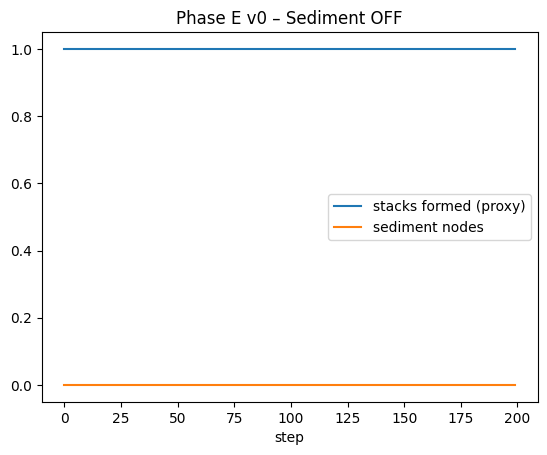

In [5]:
# Run OFF: no sediment filter
channels, broker, selector = make_base()
stack_cfg = StackConfig(C_agg=0.001, min_size=2, max_size=3, tau_mu=0.5)  # unstable => frequent dissolves
mgr_off = StackManager(stack_cfg, sediment=None, world_id="maze_v1", phase_id="E1")
stats_off = run_loop(channels, selector, broker, steps=200, stack_mgr=mgr_off)

plot_stats(stats_off, "Phase E v0 – Sediment OFF")

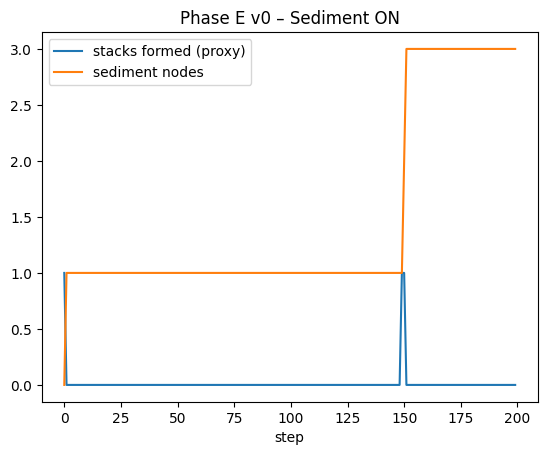

Sediment nodes: 3
Formation rejections: 197


In [6]:
# Run ON: sediment filter (phase-local)
with tempfile.TemporaryDirectory() as td:
    sediment = SedimentDAG(persist_path=Path(td)/"sediment.jsonl", truncate=True, forbid_pairs=False)
    telemetry = TelemetryLogger(path=Path(td)/"telemetry.jsonl")
    channels, broker, selector = make_base()
    mgr_on = StackManager(stack_cfg, sediment=sediment, telemetry=telemetry, world_id="maze_v1", phase_id="E1")
    stats_on = run_loop(channels, selector, broker, steps=200, stack_mgr=mgr_on)
    telemetry.close()

    plot_stats(stats_on, "Phase E v0 – Sediment ON")

    # Count rejection events
    rej = 0
    for line in (Path(td)/"telemetry.jsonl").read_text(encoding="utf-8").splitlines():
        if not line.strip():
            continue
        if json.loads(line).get("event_type") == "SEDIMENT_FORMATION_REJECTED":
            rej += 1
    print("Sediment nodes:", len(sediment.nodes()))
    print("Formation rejections:", rej)

## Notes

- With Sediment ON, you should observe sediment node growth and (often) formation rejections.
- This is *not* a performance benchmark; the goal is to validate the structural invariants (E1–E3).
